Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Forward Pass ... 
------------------------------------------------- 
linear_1:: [50, 784]
linear_1/weights
linear_1/biases
linear_2:: [50, 1200]
linear_2/weights
linear_2/biases
linear_3:: [50, 500]
linear_3/weights
linear_3/biases
softmax_4:: [50, 10]

------------------------------------------------- 
0.12
0.5
0.7
0.84
0.9
softmax_4:: [50, 10]
linear_3:: [50, 500]
linear_2:: [50, 1200]
linear_1:: [50, 784]
------------------
Accuracy on final test set: 0.820000
0: Label: 3 , Prediction: 3 , prob: 1.000000


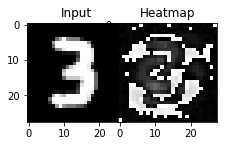

1: Label: 9 , Prediction: 9 , prob: 0.999503


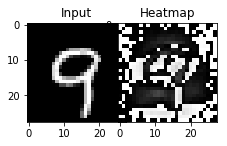

2: Label: 0 , Prediction: 0 , prob: 0.990303


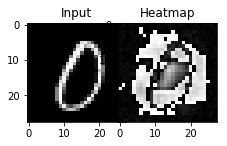

3: Label: 2 , Prediction: 2 , prob: 1.000000


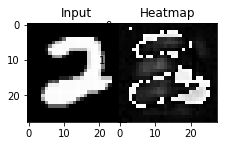

4: Label: 7 , Prediction: 7 , prob: 1.000000


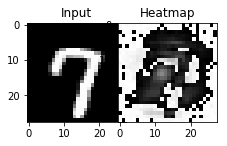

5: Label: 4 , Prediction: 4 , prob: 0.999336


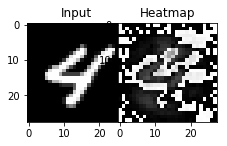

6: Label: 2 , Prediction: 2 , prob: 1.000000


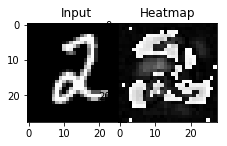

7: Label: 0 , Prediction: 5 , prob: 0.592450


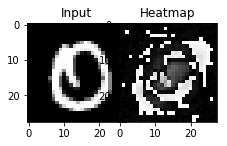

8: Label: 9 , Prediction: 9 , prob: 0.999932


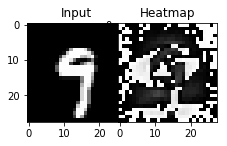

9: Label: 9 , Prediction: 9 , prob: 0.981908


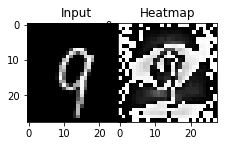

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
sys.path.append("..")
from modules.sequential import Sequential
from modules.linear import Linear
from modules.softmax import Softmax
from modules.relu import Relu
from modules.tanh import Tanh
from modules.avgpool import AvgPool
from modules.maxpool import MaxPool
from modules.convolution import Convolution
import modules.render as render
from modules.utils import Utils, Summaries, visualize
import input_data

import pylab

import tensorflow as tf
import numpy as np
%matplotlib inline

from matplotlib import pyplot as plt

# VARIABLES
batch_size = 50
learning_rate = 0.1
training_iterations = 801
dropout = 0.95

def gen_image(ax, arr, title=''):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    ax.set_title(title)
    ax.imshow(two_d, interpolation='nearest', cmap=pylab.gray())


def print_images_and_heatmaps(xs, hs, yp, yl, iterations):
    
    y_preds = np.argmax(yp, axis=1)
    y_labels = np.argmax(yl, axis=1)
    
    images = xs.reshape([batch_size,28,28])
    images = (images + 1)/2.0
    
    heatmaps = hs.reshape([batch_size,28,28])
    for i in range(iterations):
        print('%d: Label: %d , Prediction: %d , prob: %f' % (i, y_labels[i], y_preds[i], yp[i,y_preds[i]]))
        fig = plt.figure()
        ax1 = fig.add_subplot(2,2,1, adjustable='box', aspect=1)
        ax2 = fig.add_subplot(2,1,1, adjustable='box', aspect=1)

        gen_image(ax1, images[i], title='Input')
        gen_image(ax2, heatmaps[i], title='Heatmap')

        plt.show()


# input dict creation as per tensorflow source code
def feed_dict(mnist, train):    
    if train:
        xs, ys = mnist.train.next_batch(batch_size)
    else:
        xs, ys = mnist.test.next_batch(batch_size)
    return (2*xs)-1, ys

mnist = input_data.read_data_sets('data', one_hot=True)
    
with tf.Session() as sess:
    
    # GRAPH
    net = Sequential([Linear(input_dim=784,output_dim=1200, act ='relu', batch_size=batch_size, keep_prob=dropout),
                     Linear(500, act ='relu', keep_prob=dropout),
                     Linear(10, act ='linear', keep_prob=dropout),
                     Softmax()])
    
    x = tf.placeholder(tf.float32, [batch_size, 784], name='x-input')
    y_labels = tf.placeholder(tf.float32, [batch_size, 10], name='y-input')

    y_pred = net.forward(x)

    correct_prediction = tf.equal(tf.argmax(y_labels, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    trainer = net.fit(output=y_pred,ground_truth=y_labels,loss='softmax_crossentropy',optimizer='adagrad', opt_params=[learning_rate]).train
    
    tf.global_variables_initializer().run()
    
    for i in range(training_iterations):        
        feed_d = feed_dict(mnist, True)
        d = {x: feed_d[0], y_labels: feed_d[1]}
        _, pred, acc = sess.run(
          [trainer, y_pred, accuracy], feed_dict=d)
        if i % 200 == 0:
            feed_d = feed_dict(mnist, False)
            d = {x: feed_d[0], y_labels: feed_d[1]}
            acc = sess.run(accuracy, feed_dict=d)
            print(acc)
            
    # RELEVANCE
    relevance_layerwise = []
    R = y_pred
    for layer in net.modules[::-1]:
        if hasattr(layer, 'keep_prob'):
            layer.keep_prob = 1.0

#         R = net.lrp_layerwise(layer, R, 'alphabeta', 0.9)
        R = net.lrp_layerwise(layer, R, 'epsilon', 0.05)
#         R = net.lrp_layerwise(layer, R, 'ww')
#         R = net.lrp_layerwise(layer, R, 'flat')
        relevance_layerwise.append(R)
    
    feed_d = feed_dict(mnist, False)
    d = {x: feed_d[0], y_labels: feed_d[1]}
    
    y_pred, rels, acc = sess.run([y_pred, relevance_layerwise, accuracy], feed_dict=d)
    print("------------------")
    print("Accuracy on final test set: %f" % acc)    
    print_images_and_heatmaps(d[x], rels[-1], y_pred, d[y_labels], 10)
    
        
